# Домашнее задание №9
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

Mobile Games AB Testing with Cookie Cats

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy 
from scipy import stats
from scipy.stats import shapiro

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

import statsmodels as sm
from statsmodels.stats.power import TTestIndPower

Подготовим данные, загрузим и проверим корректность отображения.

In [3]:
df = pd.read_csv('cookie_cats 2.csv')
df.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
5,540,gate_40,187,1,1
6,1066,gate_30,0,0,0
7,1444,gate_40,2,0,0
8,1574,gate_40,108,1,1
9,1587,gate_40,153,1,0


Проверим столбцы на правильность типов и наличие нулевых значений

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [6]:
df.shape

(90189, 5)

In [7]:
df.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189.000000,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.445210,0.186065
std,2.883286e+06,195.050858,0.496992,0.389161
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000,0.000000
50%,4.995815e+06,16.000000,0.000000,0.000000
75%,7.496452e+06,51.000000,1.000000,0.000000
max,9.999861e+06,49854.000000,1.000000,1.000000


In [8]:
df.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

Посмотрим количество пользователей в каждой из групп

In [9]:
df.version.value_counts()

version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

Проверим не попали ли одни и те же пользователи в разные выборки

In [17]:
df.userid.nunique()

90189

In [18]:
from scipy.stats import kstest
print(kstest(df['sum_gamerounds'][df.version == 'gate_30'], 'norm'))
print(kstest(df['sum_gamerounds'][df.version == 'gate_40'], 'norm'))

KstestResult(statistic=0.8724176532867202, pvalue=0.0)
KstestResult(statistic=0.8707186187388001, pvalue=0.0)


Распределение не нормальное

In [20]:
from scipy.stats import mannwhitneyu
mannwhitneyu(df[df.version == 'gate_30'].sum_gamerounds,
             df[df.version == 'gate_40'].sum_gamerounds)

MannwhitneyuResult(statistic=1024331250.5, pvalue=0.05020880772044255)

Text(0.5, 1.0, 'Количество раундов на игрока')

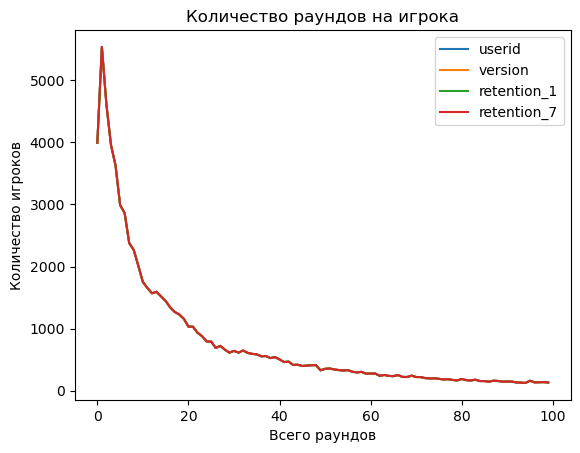

In [24]:
plot_df = df.groupby('sum_gamerounds').count()

ax = plot_df[:100].plot()
ax.set_xlabel('Всего раундов')
ax.set_ylabel('Количество игроков')
ax.set_title('Количество раундов на игрока')
     

In [32]:

plt.style.use('ggplot')

Group_A = df[df.version == 'gate_30']

Group_B = df[df.version == 'gate_40']

bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500]
plot_GA = pd.DataFrame(Group_A.groupby(pd.cut(Group_A['sum_gamerounds'],
                                              bins=bins)).count())
plot_GB = pd.DataFrame(Group_B.groupby(pd.cut(Group_B['sum_gamerounds'],
                                              bins=bins)).count())

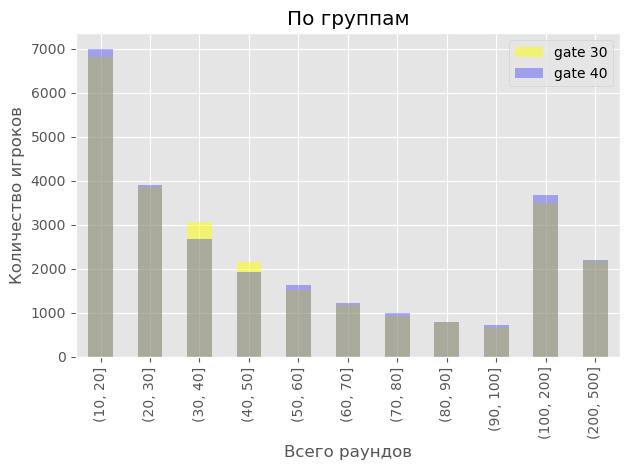

In [40]:
ax = plot_GA.plot(kind = 'bar', y='userid', color = 'yellow', alpha = 0.5,
                  title = 'По группам')
plot_GB.plot(kind = 'bar', y = 'userid', ax = ax, color = 'blue', alpha = 0.3)
ax.set_xlabel('Всего раундов')
ax.set_ylabel('Количество игроков')
plt.legend(['gate 30', 'gate 40'])
plt.tight_layout()
plt.grid(True)

In [46]:
control = df.query('version == "gate_30"')

test = df.query('version == "gate_40"')

In [72]:
control['retention_1'].sum() / control['retention_1'].count()

0.4481879194630872

In [95]:
control['retention_7'].sum() / control['retention_7'].count()

0.19020134228187918

In [96]:
test['retention_1'].sum() / test['retention_1'].count()

0.44228274967574577

In [97]:
test['retention_7'].sum() / test['retention_7'].count()

0.18200004396667327

In [93]:
control['retention_1'].sum() / control['retention_1'].count() - test['retention_1'].sum() / test['retention_1'].count()

0.005905169787341458

In [94]:
control['retention_7'].sum() / control['retention_7'].count() - test['retention_7'].sum() / test['retention_7'].count()

0.008201298315205913

In [75]:
mw_stats = scipy.stats.mannwhitneyu(x=control['retention_7'].sum() / control['retention_7'].count(), y = test['retention_7'].sum() / test['retention_7'].count())

mw_stats

MannwhitneyuResult(statistic=1.0, pvalue=1.0)

In [ ]:
воспользуемся Bootstrapp

In [83]:
boot_1d = []
for i in range(500):
  boot_mean = df.retention_1.sample(frac=1, replace=True).groupby(df.version).mean()
  boot_1d.append(boot_mean)

boot_1d = pd.DataFrame(boot_1d)
print(boot_1d)

version       gate_30   gate_40
retention_1  0.448007  0.439780
retention_1  0.445028  0.442923
retention_1  0.449414  0.440230
retention_1  0.451591  0.442570
retention_1  0.449316  0.441693
...               ...       ...
retention_1  0.446874  0.444910
retention_1  0.449146  0.441641
retention_1  0.442722  0.438991
retention_1  0.446367  0.440521
retention_1  0.453379  0.440796

[500 rows x 2 columns]


Text(0.5, 0, 'Среднее удержание 1 дня')

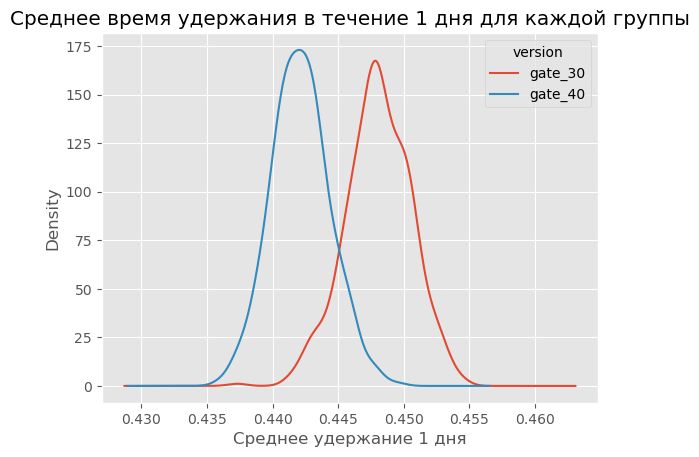

In [86]:
ax = boot_1d.plot.kde()
ax.set_title('Среднее время удержания в течение 1 дня для каждой группы')
ax.set_xlabel('Среднее удержание 1 дня')

Text(0.5, 1.0, 'Zooming % difference')

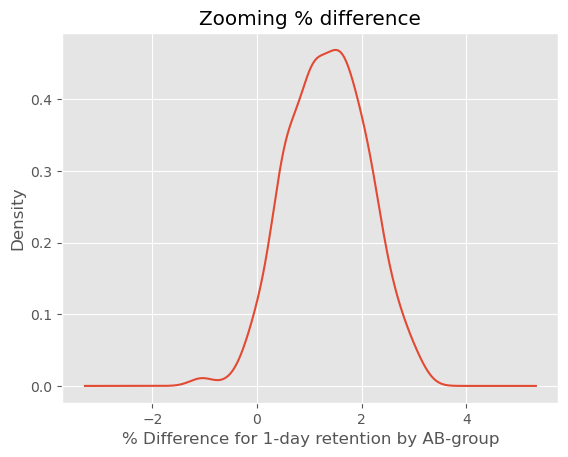

In [87]:
boot_1d['difference'] = (boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40']*100

ax = boot_1d['difference'].plot.kde()
ax.set_xlabel('% Difference for 1-day retention by AB-group')
ax.set_title('Zooming % difference')

In [88]:
prob = (boot_1d['difference'] > 0).sum() / len(boot_1d['difference'])
print(str(prob*100)+'%')

97.0%


То же саоме для Retention 7 дней

In [89]:
boot_7d = []
for i in range(500):
  boot_mean = df.retention_7.sample(frac=1, replace=True).groupby(df.version).mean()
  boot_7d.append(boot_mean)

boot_7d = pd.DataFrame(boot_7d)
print(boot_7d.head())

boot_7d['diff'] = (boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100

version       gate_30   gate_40
retention_7  0.190865  0.183792
retention_7  0.186932  0.178046
retention_7  0.190523  0.179481
retention_7  0.191450  0.182768
retention_7  0.189585  0.180864


1.0


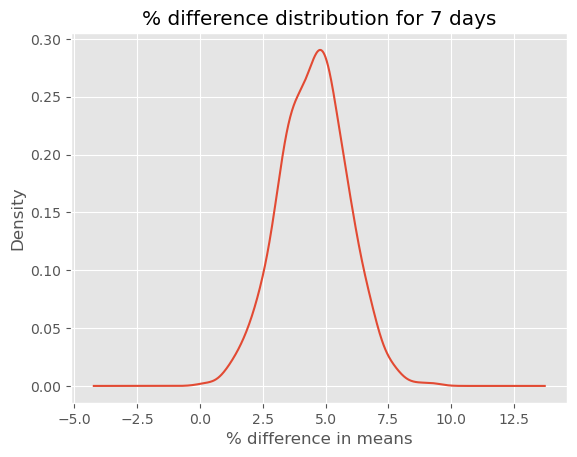

In [91]:
ax = boot_7d['diff'].plot.kde()
ax.set_xlabel('% difference in means')
ax.set_title('% difference distribution for 7 days')

prob = (boot_7d['diff'] > 0).sum() / len(boot_7d['diff'])

print(prob)

In [92]:
prob = (boot_7d['diff'] > 0).sum() / len(boot_7d['diff'])
print(str(prob*100)+'%')

100.0%


Результат бутстрап-анализа говорит о том, что есть вероятность (99,8%) того, что удержание пользователей на 7-й день выше, когда ворота находятся на уровне 30, чем когда на уровне 40.

Вывод заключается в следующем: 
* если мы хотим сохранить высокий уровень удержания пользователей - как на 1-й, так и на 7-й день, - нам не следует перемещать ворота с уровня 30 на уровень 40. 
* рассмотреть другие показатели, такие как количество сыгранных раундов или объем внутриигровых покупок, чтобы определить статистически значимые различия.
* проверить желаемый уровень изменения показателя и достаточно ли мощности теста, для выводов